In [ ]:
import pandas as pd
from sklearn.utils import resample


df = pd.read_csv('Skin_text_classifier.csv')

df_h = df[['aciklama', 'hastalik']].dropna()

df_cilt = df[['aciklama', 'cilttipi']].dropna()
df_cilt = df_cilt[~df_cilt['cilttipi'].isin(['tum', 'nan', '-', 'belirsiz', 'Tüm'])]

df_balanced_list = []
max_size = df_cilt['cilttipi'].value_counts().max()

for label in df_cilt['cilttipi'].unique():
    df_label = df_cilt[df_cilt['cilttipi'] == label]
    df_label_upsampled = resample(df_label, replace=True, n_samples=max_size, random_state=42)
    df_balanced_list.append(df_label_upsampled)

df_cilt_balanced = pd.concat(df_balanced_list)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Encode
le_hastalik = LabelEncoder()
df_h['hastalik_encoded'] = le_hastalik.fit_transform(df_h['hastalik'])

# Split
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(df_h['aciklama'], df_h['hastalik_encoded'], test_size=0.2, random_state=42)

# Tokenizer & Padding
tokenizer_h = Tokenizer(oov_token='<OOV>')
tokenizer_h.fit_on_texts(X_train_h)
X_train_seq_h = tokenizer_h.texts_to_sequences(X_train_h)
X_test_seq_h = tokenizer_h.texts_to_sequences(X_test_h)
X_train_padded_h = pad_sequences(X_train_seq_h, maxlen=100, padding='post')
X_test_padded_h = pad_sequences(X_test_seq_h, maxlen=100, padding='post')

# Model(BİLSTM)
model_h = Sequential([
    Embedding(input_dim=len(tokenizer_h.word_index)+1, output_dim=128, input_length=100),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(df_h['hastalik_encoded'].unique()), activation='softmax')
])

model_h.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])


early_stop_h = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint_h = ModelCheckpoint('hastalik_model_best_bilstm.keras', monitor='val_loss', save_best_only=True)

# Fit
history_h = model_h.fit(X_train_padded_h, y_train_h, validation_data=(X_test_padded_h, y_test_h), epochs=50, batch_size=32, callbacks=[early_stop_h,checkpoint_h])

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.0995 - loss: 2.5536 - val_accuracy: 0.2210 - val_loss: 2.2892
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.3557 - loss: 2.0463 - val_accuracy: 0.6595 - val_loss: 1.1538
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.7502 - loss: 0.9201 - val_accuracy: 0.7655 - val_loss: 0.8602
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8534 - loss: 0.5612 - val_accuracy: 0.8309 - val_loss: 0.6224
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9317 - loss: 0.2752 - val_accuracy: 0.8647 - val_loss: 0.5140
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9652 - loss: 0.1535 - val_accuracy: 0.8625 - val_loss: 0.4975
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9794 - loss: 0.1005 - val_accuracy: 0.8546 - val_loss: 0.5313
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.9924 - loss: 0.0571 - val_accuracy: 0.860

In [ ]:
# Encode
le_cilt = LabelEncoder()
df_cilt_balanced['cilttipi_encoded'] = le_cilt.fit_transform(df_cilt_balanced['cilttipi'])

# Split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(df_cilt_balanced['aciklama'], df_cilt_balanced['cilttipi_encoded'], test_size=0.2, random_state=42)

# Tokenizer & Padding
tokenizer_c = Tokenizer(oov_token='<OOV>', lower=True)
tokenizer_c.fit_on_texts(X_train_c)
X_train_seq_c = tokenizer_c.texts_to_sequences(X_train_c)
X_test_seq_c = tokenizer_c.texts_to_sequences(X_test_c)
X_train_padded_c = pad_sequences(X_train_seq_c, maxlen=100, padding='post')
X_test_padded_c = pad_sequences(X_test_seq_c, maxlen=100, padding='post')

from sklearn.utils import class_weight
import numpy as np

class_weights_c = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_c), y=y_train_c)
class_weights_c = dict(enumerate(class_weights_c))

# Model (BiLSTM)
model_c = Sequential([
    Embedding(input_dim=len(tokenizer_c.word_index)+1, output_dim=128, input_length=100),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(df_cilt_balanced['cilttipi_encoded'].unique()), activation='softmax')
])

model_c.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=5e-4), metrics=['accuracy'])

early_stop_c = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
checkpoint_c = ModelCheckpoint('cilttipi_model_best_bilstm.keras', monitor='val_loss', save_best_only=True)

# Fit
history_c = model_c.fit(X_train_padded_c, y_train_c, validation_data=(X_test_padded_c, y_test_c), epochs=50, batch_size=16, class_weight=class_weights_c, callbacks=[early_stop_c,checkpoint_c])

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4908 - loss: 0.9562 - val_accuracy: 0.9512 - val_loss: 0.1803
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.9759 - loss: 0.0896 - val_accuracy: 0.9768 - val_loss: 0.0671
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.9984 - loss: 0.0115 - val_accuracy: 0.9829 - val_loss: 0.0599
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9744 - val_loss: 0.0819
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9756 - val_loss: 0.0957


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


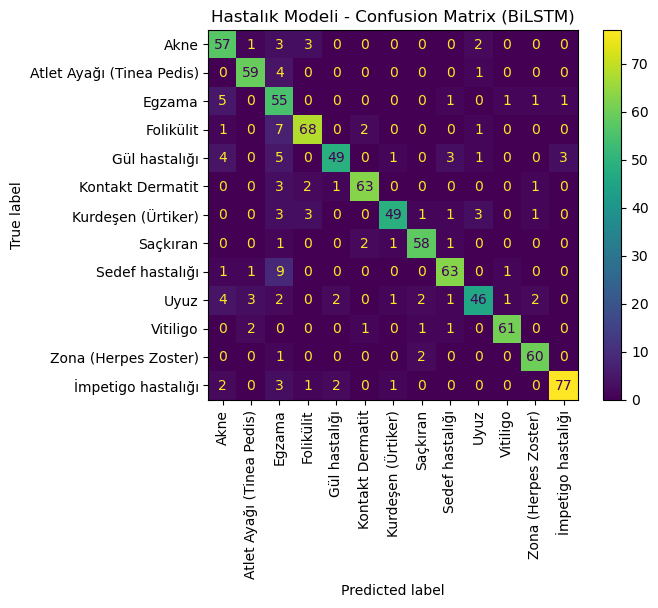

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


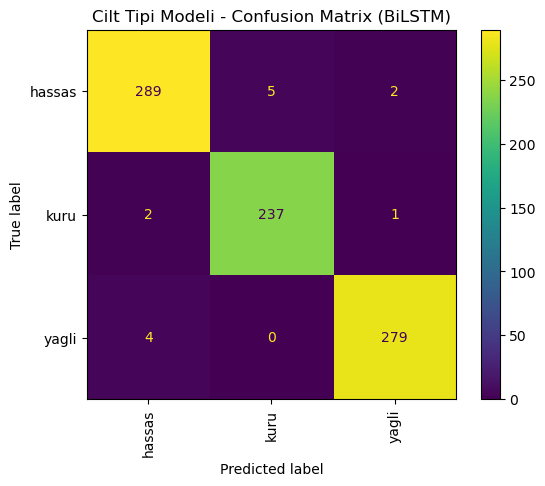

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hastalık modeli - test datası tahmini
y_pred_h = model_h.predict(X_test_padded_h).argmax(axis=1)
cm_h = confusion_matrix(y_test_h, y_pred_h)
disp_h = ConfusionMatrixDisplay(confusion_matrix=cm_h, display_labels=le_hastalik.classes_)
disp_h.plot(xticks_rotation='vertical')
plt.title('Hastalık Modeli - Confusion Matrix (BiLSTM)')
plt.show()

# Cilt tipi modeli - test datası tahmini
y_pred_c = model_c.predict(X_test_padded_c).argmax(axis=1)
cm_c = confusion_matrix(y_test_c, y_pred_c)
disp_c = ConfusionMatrixDisplay(confusion_matrix=cm_c, display_labels=le_cilt.classes_)
disp_c.plot(xticks_rotation='vertical')
plt.title('Cilt Tipi Modeli - Confusion Matrix (BiLSTM)')
plt.show()

In [5]:
def öneri_motoru(hastalik, cilttipi):
    urun = df[df['hastalik'] == hastalik]['onerilen_urun'].values[0] if not df[df['hastalik'] == hastalik].empty else 'Yok'
    cilt_urun = df[df['cilttipi'] == cilttipi]['cilt_onerilen_urun'].values[0] if not df[df['cilttipi'] == cilttipi].empty else 'Yok'
    return f"🎁 Önerilen Ürünler:\n - {urun}\n - {cilt_urun}"

def full_predict_clean(prompt):
    # Hastalık tahmini
    seq_h = tokenizer_h.texts_to_sequences([prompt])
    padded_h = pad_sequences(seq_h, maxlen=100, padding='post')
    pred_h = model_h.predict(padded_h)
    hastalik = le_hastalik.inverse_transform([pred_h.argmax()])[0]
    prob_h = pred_h.max()

    # Cilt tipi tahmini
    seq_c = tokenizer_c.texts_to_sequences([prompt])
    padded_c = pad_sequences(seq_c, maxlen=100, padding='post')
    pred_c = model_c.predict(padded_c)
    cilttipi = le_cilt.inverse_transform([pred_c.argmax()])[0]
    prob_c = pred_c.max()

    # Öneri
    recommendation = öneri_motoru(hastalik, cilttipi)

    print(f"🩺 Prompt: {prompt}")
    print(f"🏥 Tahmin Edilen Hastalık: {hastalik} (Güven: {prob_h:.2f})")
    if prob_h < 0.5:
        print("⚠ Hastalık tahmini düşük güvenle yapıldı.")
    print(f"🧴 Tahmin Edilen Cilt Tipi: {cilttipi} (Güven: {prob_c:.2f})")
    if prob_c < 0.5:
        print("⚠ Cilt tipi tahmini düşük güvenle yapıldı.")
    print(recommendation)

In [6]:
full_predict_clean("egzamam var")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
🩺 Prompt: egzamam var
🏥 Tahmin Edilen Hastalık: Akne (Güven: 0.42)
⚠ Hastalık tahmini düşük güvenle yapıldı.
🧴 Tahmin Edilen Cilt Tipi: kuru (Güven: 0.54)
🎁 Önerilen Ürünler:
 - Benzoyl Peroxide %5-10, Salisilik Asit %2, Niacinamide serum, Retinoid krem
 - Seramid nemlendirici, Lipid bariyer krem, Yağ bazlı temizleyici


In [ ]:
import pickle
# Tokenizer'ları ve LabelEncoder'ları dışa aktar
with open("tokenizer_hastalik.pkl", "wb") as f:
    pickle.dump(tokenizer_h, f)

with open("tokenizer_cilt.pkl", "wb") as f:
    pickle.dump(tokenizer_c, f)

with open("le_hastalik.pkl", "wb") as f:
    pickle.dump(le_hastalik, f)

with open("le_cilt.pkl", "wb") as f:
    pickle.dump(le_cilt, f)

/var/folders/fj/49__nmss1vq863jvp8hjmy7r0000gn/T/ipykernel_40303/888500651.py:25: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127973 (\N{HOSPITAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


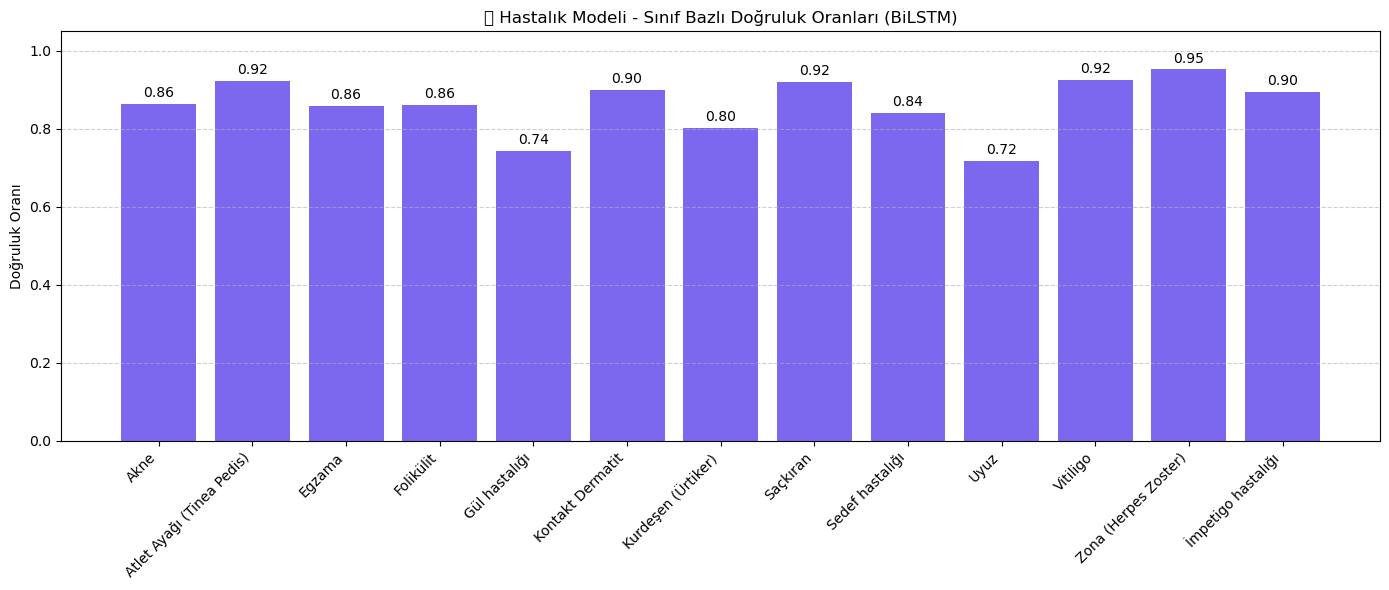

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm_h = confusion_matrix(y_test_h, y_pred_h)

success_rates_h = cm_h.diagonal() / cm_h.sum(axis=1)
classes_h = le_hastalik.classes_

# Grafik
plt.figure(figsize=(14, 6))
bars = plt.bar(classes_h, success_rates_h, color='mediumslateblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("Doğruluk Oranı")
plt.title("🏥 Hastalık Modeli - Sınıf Bazlı Doğruluk Oranları (BiLSTM)")
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar, acc in zip(bars, success_rates_h):
    plt.text(bar.get_x() + bar.get_width() / 2, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
